# Project: Financial Inclusion in Africa.

**Table of Contents:**

<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#wrangle">Data Wrangling</a></li>
    <li><a href="#process">Data Preprocessing</a></li>
    <li><a href="#model">Modelling</a></li>
</ul>


<a id="intro"></a>

## Introduction.

Financial Inclusion remains to be one of the main obstacles to economic and human development in Africa. For example, across Kenya, Uganda, Tanzania and Rwanda, only 9.1 million adults have access or use a commercial bank account.

Import the libraries required for machine learning

In [36]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline


from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost

from sklearn.model_selection import train_test_split,GridSearchCV,KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV    
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score,average_precision_score, precision_score, confusion_matrix, classification_report

import warnings 
warnings.filterwarnings('ignore')

### Data Overview.

In [2]:
train_df = pd.read_csv('Train_v2.csv')
test_df  = pd.read_csv('Test_v2.csv')
print(train_df.shape, test_df.shape)

(23524, 13) (10086, 12)


In [3]:
full_data = [train_df, test_df]
print (train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


<a id='wrangle'></a>

## Data Wrangling

In [4]:
df = train_df.copy()
print('This dataset contains ',df.shape[0],'rows')
print('This dataset contains ',df.shape[1],'columns')

This dataset contains  23524 rows
This dataset contains  13 columns


In [5]:
# Remove trailing whitespaces

def remove_spaces(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = df[col].str.strip()

remove_spaces(df) 

In [6]:
# Checking the missing values

missing_df =df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column Name', 'Missing Values Count']
missing_df['Filling Factor (%)']=(df.shape[0]-missing_df['Missing Values Count'])/df.shape[0]*100
missing_df.sort_values('Filling Factor (%)').reset_index(drop = True)

,Column Name,Missing Values Count,Filling Factor (%)
0,country,0,100.0
1,year,0,100.0
2,uniqueid,0,100.0
3,bank_account,0,100.0
4,location_type,0,100.0
5,cellphone_access,0,100.0
6,household_size,0,100.0
7,age_of_respondent,0,100.0
8,gender_of_respondent,0,100.0
9,relationship_with_head,0,100.0


There are no missing values in the dataset

In [7]:
df.duplicated().sum()

0

No duplicated values

### Exploratory Data Analysis (EDA)

#### Univariate Analysis

--> What is the distribution of bank accounts?

In [8]:
bank_accounts = df['bank_account'].value_counts()
bank_accounts

No     20212
Yes     3312
Name: bank_account, dtype: int64

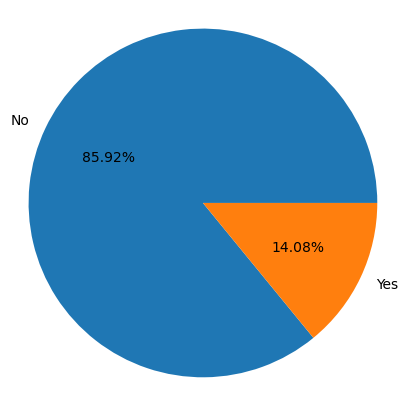

In [9]:
plt.figure(figsize=(5,5))

plt.pie(bank_accounts.values, labels=bank_accounts.index, autopct = '%1.2f%%')
plt.axis('square')
plt.show()

From the above chart, approximately 86% of the population do not have access to bank accounts.

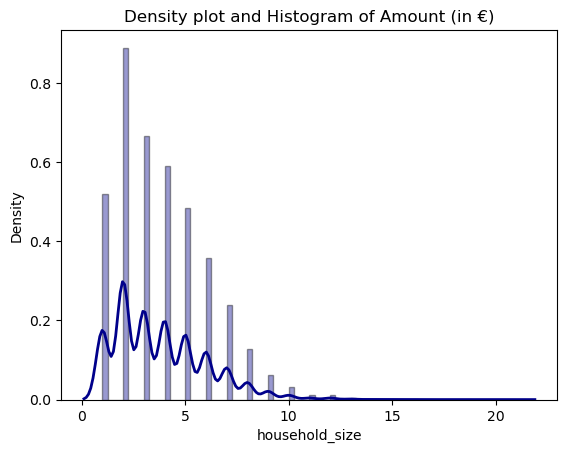

In [10]:
sns.distplot(df.household_size, 
             bins=80, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Density plot and Histogram of Amount (in €)')
plt.show()

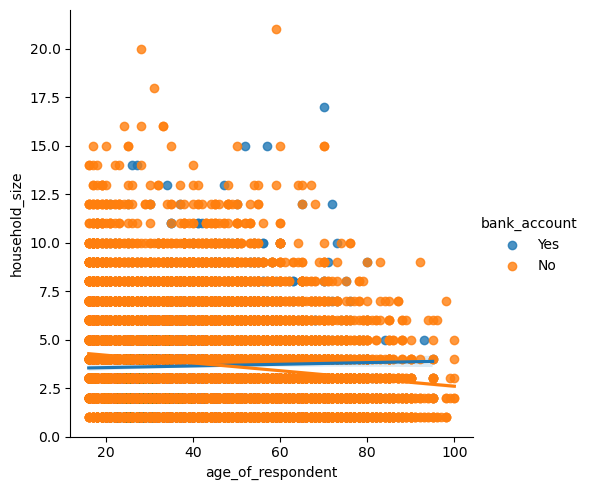

In [11]:
sns.lmplot(x = 'age_of_respondent', y= 'household_size', hue = 'bank_account',data = df)

<AxesSubplot:>

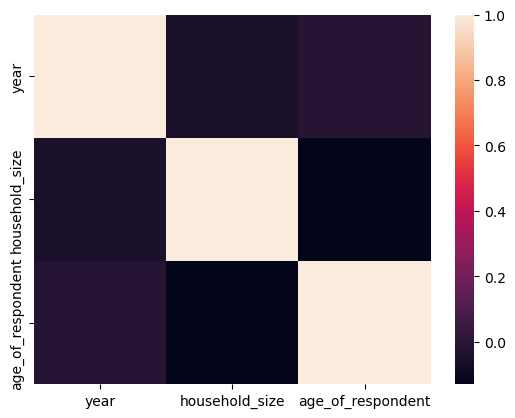

In [12]:
# Generating the correlation heatmap

corr = df.corr()
sns.heatmap(corr)

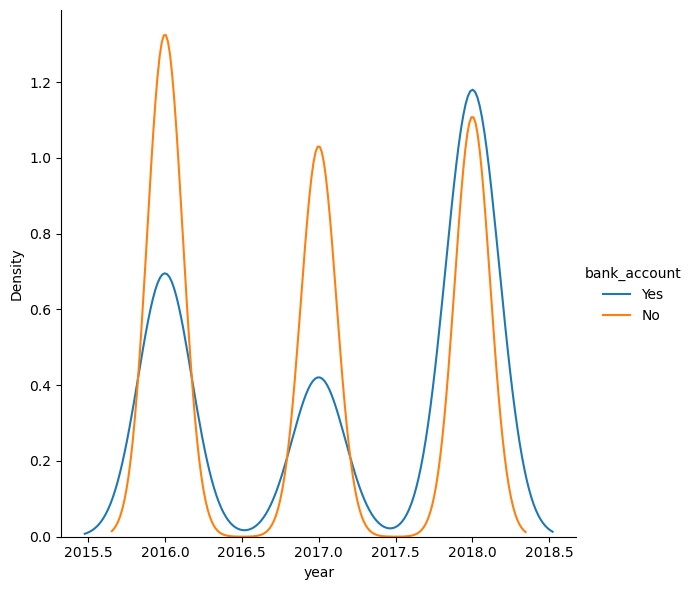

In [13]:
# Distribution density plot KDE (kernel density estimate)

sns.FacetGrid(df, 
              hue="bank_account", 
              height=6).map(sns.kdeplot, "year").add_legend()
plt.show()

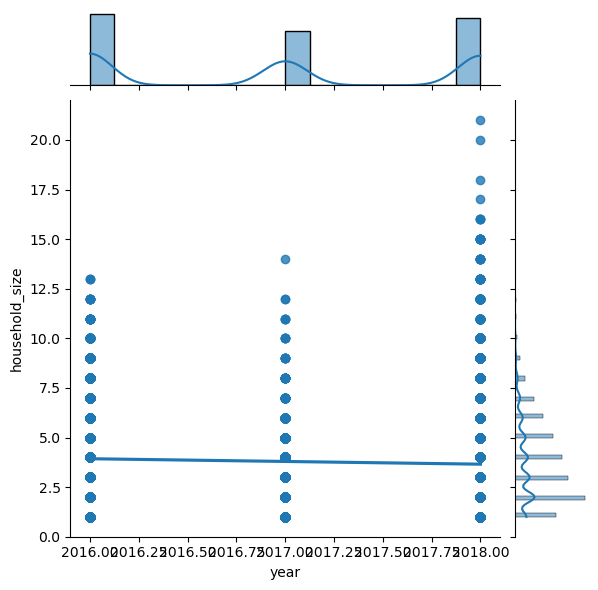

In [14]:
sns.jointplot("year", "household_size", data=df, kind="reg")

In [15]:
df.drop(['uniqueid'],inplace=True,axis=1)

<a id='processing'><a/>

## Data Preprocessing

Convert target variable to binary.

In [16]:
df['bank_account'] = np.where(df['bank_account'] == 'Yes', 1,0)

In [17]:
df.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [18]:
# Converted to binary the target to help later with  Modelling and Plots 

# df['bank_account'] = df['bank_account'].map({'Yes':1, 'No':0})

<AxesSubplot:>

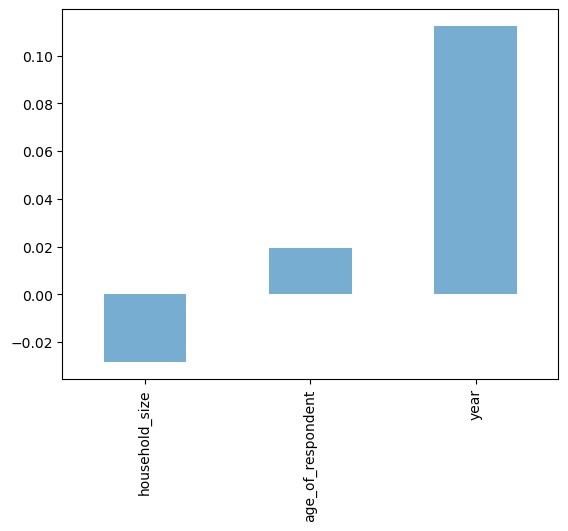

In [19]:
tst = df.corr()['bank_account']
tst = tst.drop('bank_account')
tst.sort_values(inplace=True)
tst.plot(kind='bar', alpha=0.6)

In [20]:
L_en = LabelEncoder()
O_en = OneHotEncoder(sparse=False)

one_hot_categories = ['country','education_level','gender_of_respondent','location_type','job_type', 'cellphone_access', 'relationship_with_head', 'marital_status'] #attributes to convert to 1hot

for category in one_hot_categories: #iterate over attributes
    out1 = L_en.fit_transform(df[[category]].values.ravel())    
    out2 = O_en.fit_transform(out1.reshape(-1,1)).astype('int')

    for i, name in enumerate(L_en.classes_):
            df[name] = out2[:,i] # make new column filled with 0s, 1s

df.drop(one_hot_categories , axis=1, inplace=True) #drop original colsdf

In [21]:
# df['bank_account']=df['bank_account'].map({'Yes':1,'No':0})

In [22]:
df.head()

,year,bank_account,household_size,age_of_respondent,Kenya,Rwanda,Tanzania,Uganda,No formal education,Other/Dont know/RTA,...,Head of Household,Other non-relatives,Other relative,Parent,Spouse,Divorced/Seperated,Dont know,Married/Living together,Single/Never Married,Widowed
0,2018,1,3,24,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,2018,0,5,70,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,2018,1,5,26,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,2018,0,5,34,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,2018,0,8,26,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
# Normalizing the dataset

X = df.drop('bank_account', axis=1)  
y = df['bank_account'].values

minmax_scale = MinMaxScaler()
X = minmax_scale.fit_transform(X)

In [24]:
print(X.shape)
print(y.shape)

(23524, 40)
(23524,)


In [25]:
#Split dataset into 70% train, 30% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### KNearest Neighbors

In [26]:
#Performing cross validation
neighbors = []
cv_scores = []

#perform 10 fold cross validation
for k in range(1,24):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn,X_train,y_train,cv=10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

The Optimal number of Neighbors is 16 


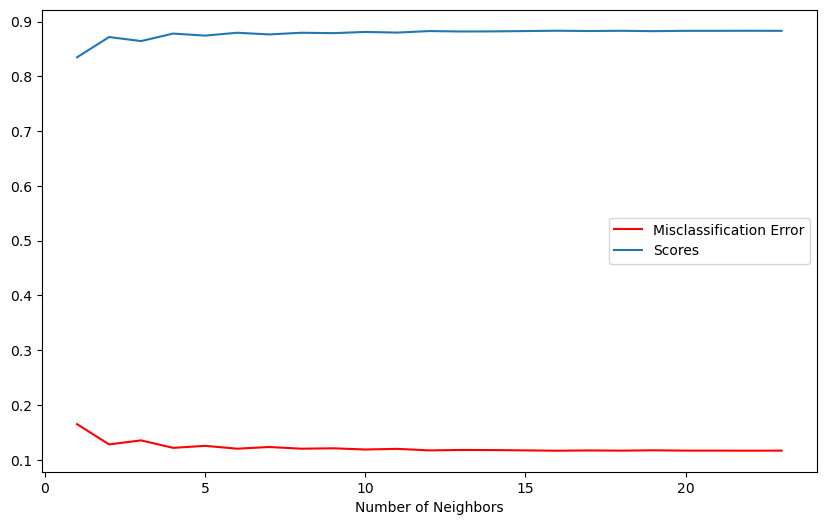

In [27]:
#Misclassification error versus k
MSE = [1-x for x in cv_scores]

#determining the best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('The Optimal number of Neighbors is %d ' %optimal_k)

#plot misclassification error versus k

plt.figure(figsize = (10,6))
plt.plot(neighbors, MSE, label = 'Misclassification Error', c = 'red')
plt.plot(neighbors, cv_scores, label = 'Scores')
plt.xlabel('Number of Neighbors')
# plt.ylabel('Misclassification Error')
plt.legend()
plt.show()

--Classification Report--
              precision    recall  f1-score   support

           0       0.90      0.98      0.93      6047
           1       0.71      0.31      0.44      1011

    accuracy                           0.88      7058
   macro avg       0.80      0.65      0.69      7058
weighted avg       0.87      0.88      0.86      7058

--Confusion Matrix--


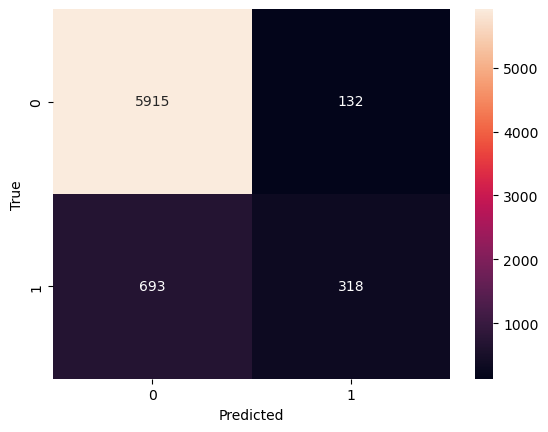

In [28]:
knn = KNeighborsClassifier(n_neighbors = 16)

knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn.score(X_test,y_test)
# print('--Accuracy Score--')
# knn.score(y_test,knn_pred.ravel())
print('--Classification Report--')
print(classification_report(y_test, knn_pred))
print('--Confusion Matrix--')
cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}


In [30]:
models = []
models.append(('Logistic Regression',LogisticRegression()))
models.append(('Linear Discriminant Analysis',LinearDiscriminantAnalysis()))
models.append(('Quadratic Discriminnat Analysis',QuadraticDiscriminantAnalysis()))
models.append(('Support Vector Machine',SVC(gamma='scale')))

ensembles = []
ensembles.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=100)))
ensembles.append(('Ada Boost Classifier', AdaBoostClassifier()))
ensembles.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
ensembles.append(('XGB Classifier', XGBClassifier()))

In [31]:
# Models evaluation function
def get_score_models(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    # All our models implement the 'decision_function' method
    # It is not the case of all our ensembles
    y_score = model.decision_function(X_test)
    
    compare(y_test,y_pred,y_score)
    
# Ensembles evaluation function
def get_score_ensembles(ensemble,X_train,X_test,y_train,y_test):
    ensemble.fit(X_train,y_train)
    y_pred = ensemble.predict(X_test)
    
    # All our ensembles implement the 'predict_proba' method
    # It is not the case of all our models
    y_score = ensemble.predict_proba(X_test)[:,1]
    
    compare(y_test,y_pred,y_score)

# Print metrics and graph function
def compare(y_test,y_pred,y_score):
    print('Confusion matrix:')
    print(confusion_matrix(y_test,y_pred))
    
    print('Recall:',recall_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('Area under the curve:',average_precision_score(y_test,y_score))
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.step(recall, precision, alpha=0.4, color='b', where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')
    plt.show()

---------- Logistic Regression ----------
Confusion matrix:
[[5895  152]
 [ 656  355]]
Recall: 0.35113748763600394
Precision: 0.7001972386587771
Area under the curve: 0.5752178068068314


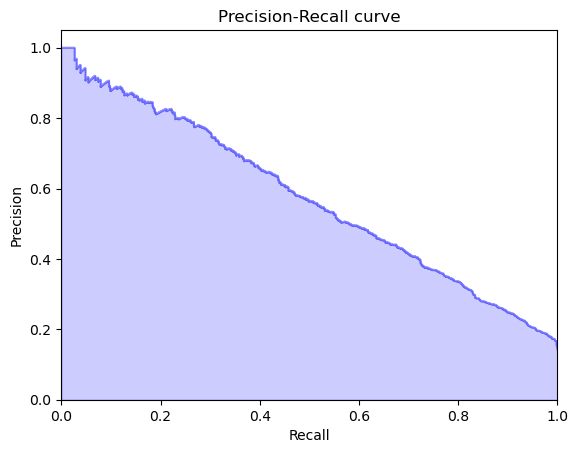

---------- Linear Discriminant Analysis ----------
Confusion matrix:
[[5798  249]
 [ 605  406]]
Recall: 0.40158259149357073
Precision: 0.6198473282442748
Area under the curve: 0.5652660560359627


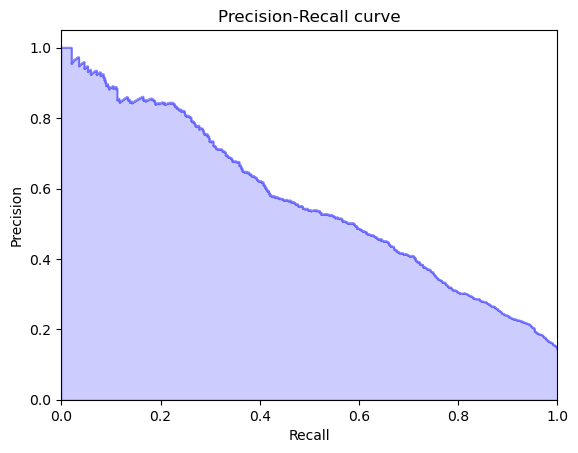

---------- Quadratic Discriminnat Analysis ----------
Confusion matrix:
[[5323  724]
 [ 471  540]]
Recall: 0.5341246290801187
Precision: 0.4272151898734177
Area under the curve: 0.4794692430833532


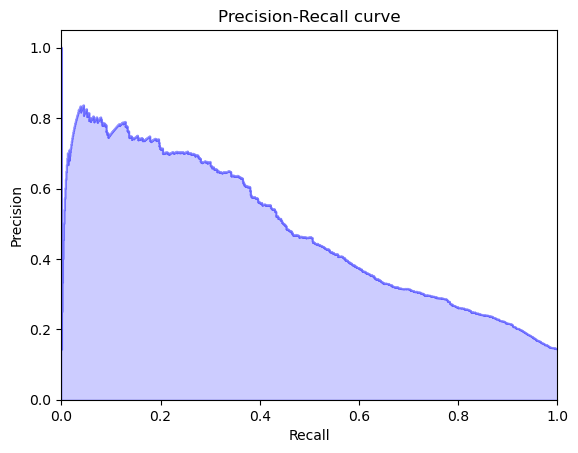

---------- Support Vector Machine ----------
Confusion matrix:
[[5930  117]
 [ 677  334]]
Recall: 0.3303659742828882
Precision: 0.7405764966740577
Area under the curve: 0.551597245231503


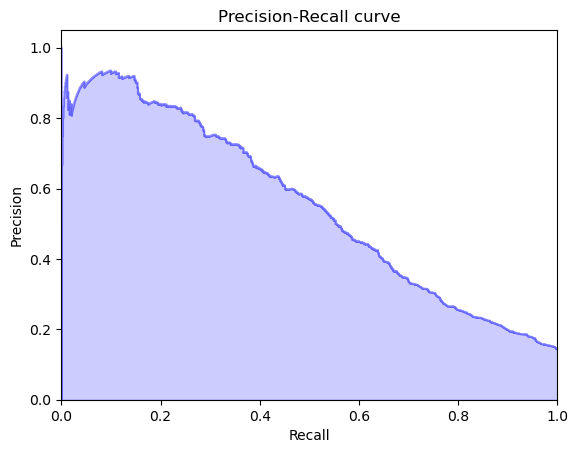

In [32]:
# Evaluation of each model
for name,model in models:
    print('----------',name,'----------')
    get_score_models(model,X_train,X_test,y_train,y_test)

---------- Random Forest Classifier ----------
Confusion matrix:
[[5718  329]
 [ 593  418]]
Recall: 0.4134520276953511
Precision: 0.5595716198125836
Area under the curve: 0.5005738260130624


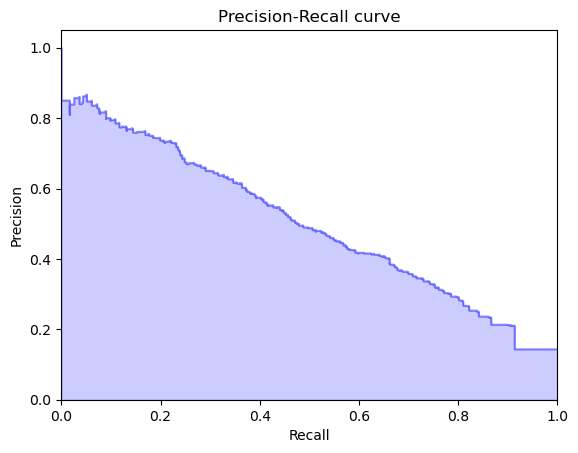

---------- Ada Boost Classifier ----------
Confusion matrix:
[[5905  142]
 [ 662  349]]
Recall: 0.34520276953511375
Precision: 0.7107942973523421
Area under the curve: 0.5714413471442109


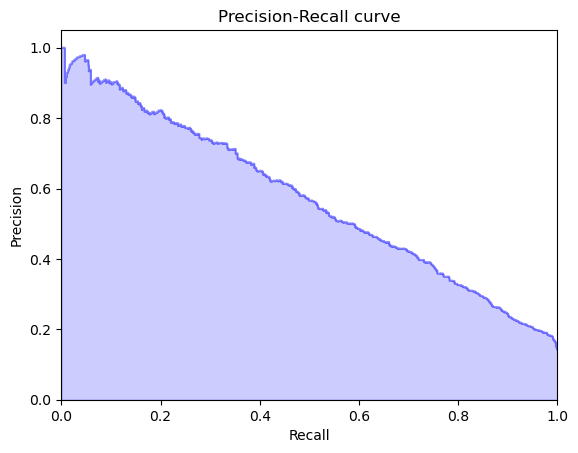

---------- Gradient Boosting Classifier ----------
Confusion matrix:
[[5920  127]
 [ 660  351]]
Recall: 0.34718100890207715
Precision: 0.7343096234309623
Area under the curve: 0.6008519327520113


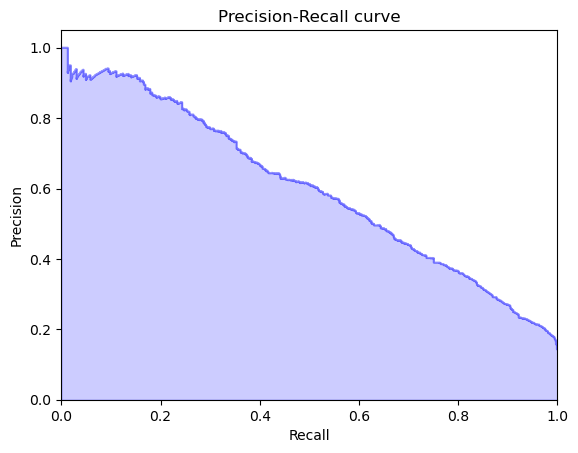

---------- XGB Classifier ----------
[14:36:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix:
[[5847  200]
 [ 611  400]]
Recall: 0.39564787339268054
Precision: 0.6666666666666666
Area under the curve: 0.5804991489525747


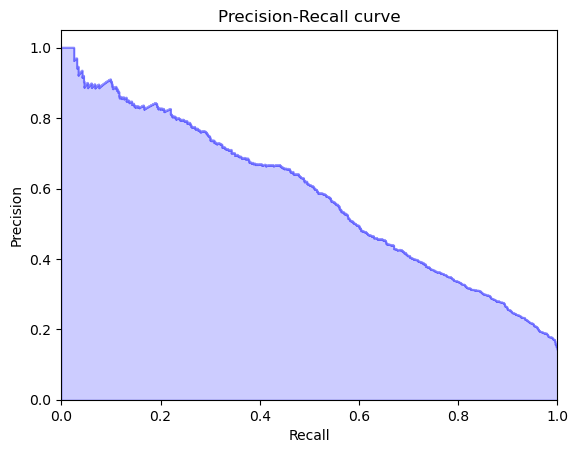

In [33]:
# Evaluation of each ensemble method
for name,ensemble in ensembles:
    print('----------',name,'----------')
    get_score_ensembles(ensemble,X_train,X_test,y_train,y_test)

Text(0, 0.5, 'explained_variance_ratio_')

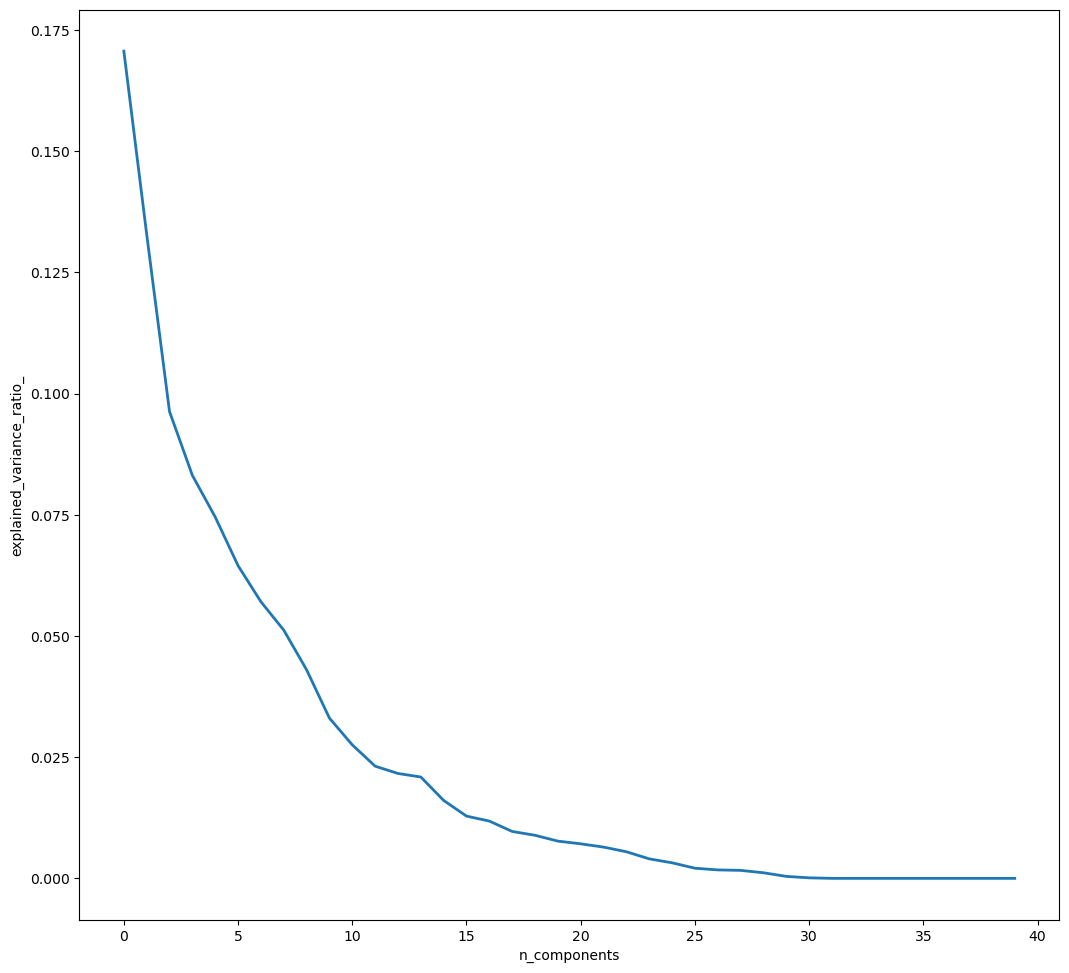

In [34]:
# Normalization of the data

x_train_N = (X_train-X_train.mean())/(X_train.max()-X_train.min())
x_test_N = (X_test-X_test.mean())/(X_test.max()-X_test.min())

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')


#### Hyper Parameter Tuning

Selecting best model

In [35]:
model_params = {
    'logreg' : {'model' : LogisticRegression( solver = 'liblinear', multi_class = 'auto'),
                'params' : {
                    'C' : [1 , 10, 20]
                }},
    
   #  'gaussian' : {'model' : GaussianNB()},
    
    'DTC' : {'model' : DecisionTreeClassifier(),
             'params' : {
               #  'max_features': ['log2', 'sqrt','auto'], 
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 3, 5], 
                'min_samples_split': [2, 3, 5]
               #  'min_samples_leaf': [1, 5, 8, 10]
             }},
    
    'RFC' : {'model' : RandomForestClassifier(),
             'params' : {
               'n_estimators': [4, 6, 10], 
               'max_features': ['log2', 'sqrt','auto'], 
               'criterion': ['entropy'],
               'max_depth': [2, 3, 5], 
               # 'min_samples_split': [2, 3, 5],
               # 'min_samples_leaf': [1, 5, 8]
             }},
    
    'svm' : {'model': SVC(gamma = 'auto'),
             'params' : {
                'C': [1, 10, 20], 
                'kernel': ['linear' , 'rbf']
               #  'gamma': [0.001, 0.0001, 'auto'],
               #  'degree':[1,3,10]
                }},
    
    'knn' : {'model' : KNeighborsClassifier(),
             'params' : {
                'n_neighbors': [3, 4, 5, 10], 
                'weights': ['uniform', 'distance'],
               #  'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               #  'leaf_size' : [10, 20, 30]
             }}
}

scores = []

for model_name, mp in model_params.items():
       clf = GridSearchCV( mp['model'], mp['params'], cv = 5, return_train_score=False)
       clf.fit(X_train, y_train)
       scores.append({
          'model' : model_name,
          'best_score' : clf.best_score_,
          'best_params' : clf.best_params_
       })
       print('{} Completed'.format(model_name))
            
scoreFrame = pd.DataFrame( scores, columns = ['model', 'best_score', 'best_params'])
scoreFrame

logreg Completed
DTC Completed
RFC Completed
svm Completed
knn Completed


,model,best_score,best_params
0,logreg,0.885218,{'C': 1}
1,DTC,0.882121,"{'criterion': 'gini', 'max_depth': 5, 'min_sam..."
2,RFC,0.877262,"{'criterion': 'entropy', 'max_depth': 5, 'max_..."
3,svm,0.886858,"{'C': 20, 'kernel': 'rbf'}"
4,knn,0.881513,"{'n_neighbors': 10, 'weights': 'uniform'}"


## SVM Classifier


In [37]:

# Creating scaled set to be used in model to improve the results

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [38]:
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [39]:
test_df['unique_id'] = test_df[['uniqueid','country']].apply(lambda x: ' x '.join(x), axis=1)
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,unique_id
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,uniqueid_6056 x Kenya
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,uniqueid_6060 x Kenya
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,uniqueid_6065 x Kenya
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,uniqueid_6072 x Kenya
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,uniqueid_6073 x Kenya


In [ ]:
# submission = pd.DataFrame()
# submission['unique_id'] = test_df['unique_id']
# submission['bank_account'] = predictions.reshape((predictions.shape[0]))
# submission.to_csv('submission_df.csv',index=False)

### Other Models

In [41]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=200)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
#metrics

import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)

[15:38:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8836780957778407